In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

ImportError: Could not find the DLL(s) 'msvcp140_1.dll'. TensorFlow requires that these DLLs be installed in a directory that is named in your %PATH% environment variable. You may install these DLLs by downloading "Microsoft C++ Redistributable for Visual Studio 2015, 2017 and 2019" for your platform from this URL: https://support.microsoft.com/help/2977003/the-latest-supported-visual-c-downloads

In [6]:
pip install tensorflow

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.8.0
    Uninstalling typing_extensions-4.8.0:
      Successfully uninstalled typing_extensions-4.8.0
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastapi 0.104.1 requires typing-extensions>=4.8.0, but you have typing-extensions 4.5.0 which is incompatible.
pydantic 2.5.2 requires typing-extensions>=4.6.1, but you have typing-extensions 4.5.0 which is incompatible.
pydantic-core 2.14.5 requires typing-extensions!=4.7.0,>=4.6.0, but you have typing-extensions 4.5.0 which is incompatible.


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


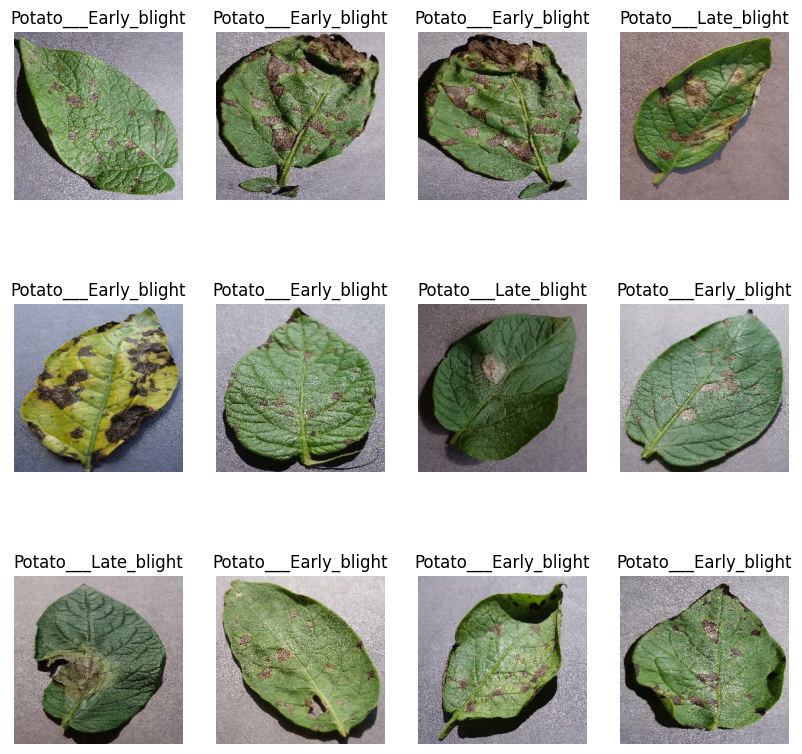

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

68

In [8]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [11]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

54

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [18]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [19]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models

def residual_block(x, filters, kernel_size=3, stride=1):
    # Shortcut
    shortcut = x
    
    # First convolution
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Second convolution
    x = layers.Conv2D(filters, kernel_size=kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Adjust shortcut dimensions if needed
    if stride != 1 or x.shape[-1] != shortcut.shape[-1]:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
    
    # Add shortcut to the output
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    
    return x

def build_resnet(input_shape, num_classes):
    input_tensor = tf.keras.Input(shape=input_shape)
    
    # Initial convolution
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Max pooling
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
    
    # Residual blocks
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=128, stride=2)
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=256, stride=2)
    x = residual_block(x, filters=256)
    
    # Global average pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    # Fully connected layer
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    # Output layer
    output_tensor = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=input_tensor, outputs=output_tensor)
    return model

# Assuming you have defined BATCH_SIZE, IMAGE_SIZE, CHANNELS
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

resnet_model = build_resnet(input_shape, n_classes)
resnet_model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 64)         0         ['batch_normalization[0][

In [21]:
resnet_model.compile(
    optimizer='rmsprop',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
history = resnet_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


54/54 [==============================] - 95s 1s/step - loss: 0.6046 - accuracy: 0.8258 - val_loss: 742.5368 - val_accuracy: 0.4896
Epoch 2/50
54/54 [==============================] - 73s 1s/step - loss: 0.2504 - accuracy: 0.9103 - val_loss: 96.4763 - val_accuracy: 0.4896
Epoch 3/50
54/54 [==============================] - 72s 1s/step - loss: 0.2180 - accuracy: 0.9265 - val_loss: 104.2430 - val_accuracy: 0.4896
Epoch 4/50
54/54 [==============================] - 73s 1s/step - loss: 0.1667 - accuracy: 0.9404 - val_loss: 5.0644 - val_accuracy: 0.2760
Epoch 5/50
54/54 [==============================] - 73s 1s/step - loss: 0.1392 - accuracy: 0.9497 - val_loss: 21.8985 - val_accuracy: 0.4896
Epoch 6/50
54/54 [==============================] - 73s 1s/step - loss: 0.1469 - accuracy: 0.9508 - val_loss: 160.3607 - val_accuracy: 0.4896
Epoch 7/50
54/54 [==============================] - 72s 1s/step - loss: 0.1277 - accuracy: 0.9554 - val_loss: 6.9493 - val_accuracy: 0.4896
Epoch 8/50

In [23]:
scores = resnet_model.evaluate(test_ds)


8/8 [==============================] - 4s 377ms/step - loss: 0.0865 - accuracy: 0.9727


In [24]:
scores


[0.08650017529726028, 0.97265625]

In [25]:
history

In [26]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [28]:
type(history.history['loss'])

list

In [29]:
len(history.history['loss'])

50

In [30]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.6045644283294678,
 0.25042423605918884,
 0.2180415242910385,
 0.16666238009929657,
 0.13923528790473938]

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

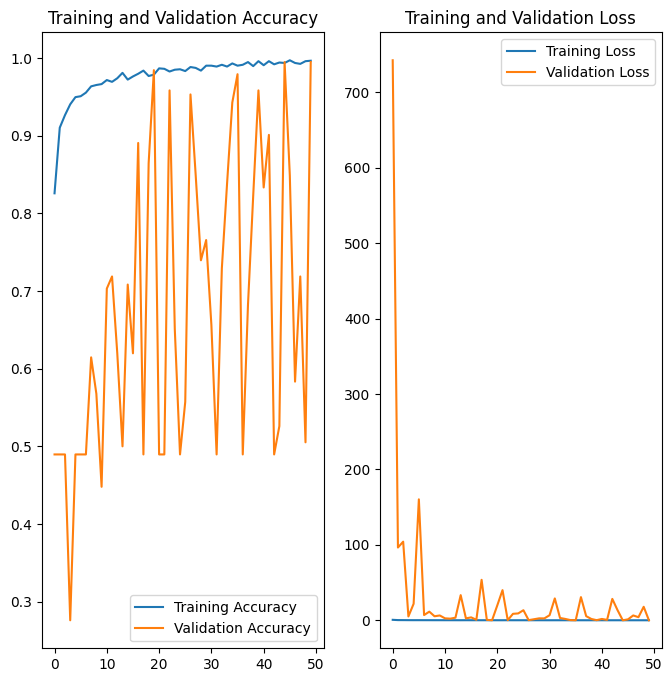

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict


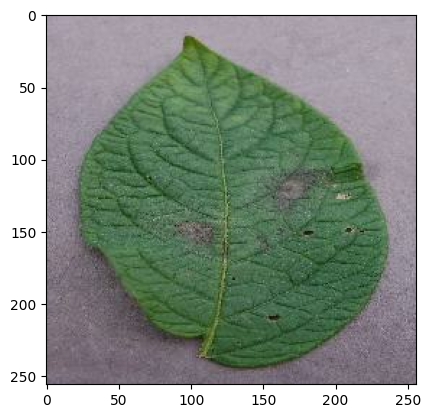

Actual label: Potato___Late_blight
1/1 [==============================] - 3s 3s/step
Predicted label: Potato___Late_blight


In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have defined class_names
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    plt.show()
    print("Actual label:", class_names[first_label])

    batch_prediction = resnet_model.predict(images_batch)
    predicted_label = class_names[np.argmax(batch_prediction[0])]
    print("Predicted label:", predicted_label)


In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 37ms/step


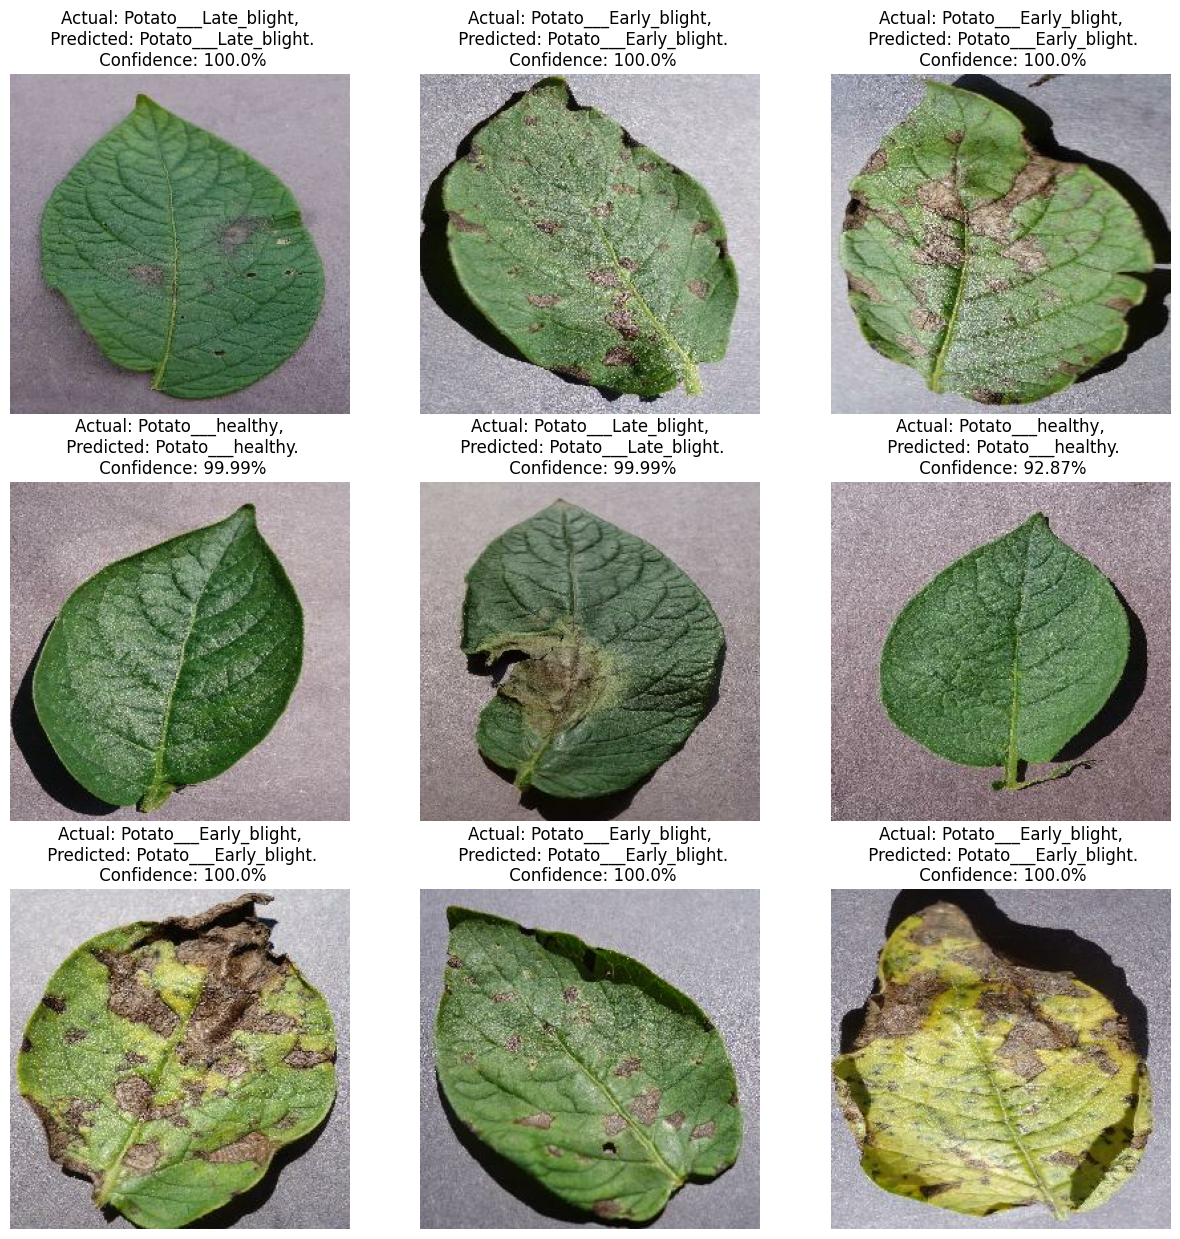

In [35]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(resnet_model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [38]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
resnet_model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


In [37]:
resnet_model.save("../resnetrms.h5")

C:\Users\ES Lab\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
